# Jupyter Example
## LAMMPS: Neb/in.neb.hop2
Reference: https://github.com/lammps/lammps/blob/master/examples/neb/in.neb.hop2 .  
Requied files: initial.hop2, final.hop2  
Description: 2d NEB surface simulation, hop of adatom on surface

In [1]:
import os
import ipyparallel as ipp
rc = ipp.Client(profile='mpi')
view = rc[:]
print("Total number of MPI tasks =",len(view))

Total number of MPI tasks = 26


In [2]:
# Set file paths
task_dir=os.getcwd()+'/'
data_init=task_dir+"initial.hop2"
data_final=task_dir+"final.hop2"
infile=task_dir+"in.neb"
logfile=task_dir+"log.lammps"

# Create an empty input file (required by LAMMPS)
file=open(infile,'w')
file.close()

In [3]:
view['task_dir']=task_dir
view['logfile']=logfile
view['infile']=infile
view['data_init']=data_init
view['data_final']=data_final

## Initialize LAMMPS

In [4]:
%%capture
%%px
from mpi4py import MPI
from lammps import PyLammps
# Use 13 images with 2 MPI tasks per image
L = PyLammps(cmdargs=["-partition","13x2","-in",infile,"-log",logfile,"-plog","none","-pscreen","none"])

## Initial minimization

In [5]:
%%time
%%px

L.dimension("2")
L.boundary("p s p")

L.atom_style("atomic")
L.neighbor("0.3 bin")
L.neigh_modify("delay 5")
L.atom_modify("map array sort 0 0.0")

L.variable("u uloop 30 pad")

# create geometry with flat surface

L.lattice("hex 0.9")
L.region("box block 0 11 0 10 -0.25 0.25")
L.region("box1 block 0 10 0 10 -0.25 0.25")
L.read_data(data_init)

# LJ potentials

L.pair_style("lj/cut 2.5")
L.pair_coeff("* * 1.0 1.0 2.5")
L.pair_modify("shift yes")

# initial minimization to relax surface

L.minimize("1.0e-6 1.0e-4 1000 10000")
L.reset_timestep("0")

CPU times: user 50 ms, sys: 2.2 ms, total: 52.2 ms
Wall time: 49.7 ms


## Nudged-elastic band calculation

In [6]:
%%time
%%px

# define groups

L.region("1 block INF INF INF 1.25 INF INF")
L.group("lower region 1")
L.group("mobile subtract all lower")
L.set("group lower type 2")

L.timestep("0.05")

# group of NEB atoms - either block or single atom ID 412

L.region("surround block 10 18 17 21 0 0 units box")
L.group("nebatoms region surround")
#L.group("nebatoms id 421")
L.set("group nebatoms type 3")
L.group("nonneb subtract all nebatoms")

L.fix("1 lower setforce 0.0 0.0 0.0")
L.fix("2 nebatoms neb 1.0 parallel ideal")
L.fix("3 all enforce2d")

L.thermo(100)

# run NEB

L.min_style("fire")
L.neb("0.0 0.05 1000 1000 100 final", data_final)

# Dump images of final structures 

L.dump(1,"all","image",1,task_dir+"neb.*.$u.jpg","type","type","zoom",1.6,"adiam",1.2,"up",0,1,0,"box","yes",0)
L.dump_modify(1,"pad",2)
L.run(0)

CPU times: user 50.6 ms, sys: 3.86 ms, total: 54.5 ms
Wall time: 112 ms


## Visualize MEP (scatter plot)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
header=['Step','MaxReplicaForce','MaxAtomForce','GradV0','GradV1','GradVc','EBF','EBR','RDT','RD1','PE1','RD2','PE2','RD3','PE3','RD4','PE4','RD5','PE5','RD6','PE6','RD7','PE7','RD8','PE8','RD9','PE9','RD10','PE10','RD11','PE11','RD12','PE12','RD13','PE13']

# Load NEB results from log.lammps
df=pd.read_csv("log.lammps", delim_whitespace=True,skiprows=9,names=header)
df

,Step,MaxReplicaForce,MaxAtomForce,GradV0,GradV1,GradVc,EBF,EBR,RDT,RD1,...,RD9,PE9,RD10,PE10,RD11,PE11,RD12,PE12,RD13,PE13
0,203,0.059642,0.051688,0.004160,0.007788,0.053846,0.001601,0.001601,1.232922,0,...,0.665406,-3.050179,0.748282,-3.050564,0.831256,-3.051053,0.914491,-3.051405,1,-3.051494
1,247,0.045664,0.018649,0.003436,0.005819,0.024332,0.001602,0.001601,1.237376,0,...,0.666668,-3.050188,0.749478,-3.050578,0.832329,-3.051068,0.915372,-3.051412,1,-3.051494


In [12]:
x=df.iloc[[1],9:35:2].values[0].tolist()
y=df.iloc[[1],10:36:2].values[0].tolist()

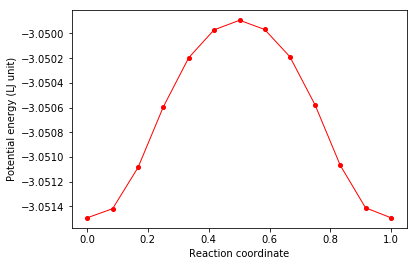

In [13]:
plt.plot(x,y,'ro',linestyle='solid', linewidth=1, markersize=4)
plt.xlabel("Reaction coordinate")
plt.ylabel("Potential energy (LJ unit)")
plt.show()

In [14]:
# Forward and Reverse enegy barrier
print("Index of maximum energy image =",np.argmax(y))
print("Forward energy barrier =",df['EBF'][1])
print("Reverse energy barrier =",df['EBR'][1])

Index of maximum energy image = 6
Forward energy barrier = 0.0016015952
Reverse energy barrier = 0.0016014343


## Visualize MEP (movie)

In [15]:
%%capture
# Use ffmpeg to make mp4 movie
!cat *.jpg | ffmpeg -y -f image2pipe -c:v mjpeg -i - -b:v 2000k -vcodec libx264 -pix_fmt yuv420p neb.mp4;

In [16]:
%%HTML
<video width="320" height="320" controls>
  <source src="neb.mp4" type="video/mp4">
</video>